In [89]:
import matplotlib.pyplot as plt

import jax
jax.config.update('jax_enable_x64', True)
jax.config.update('jax_debug_nans', False)
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from astro import get_merging_binary

n = 100_000

def get_merging_binaries(key, parameters):
    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, n)
    return key, jax.vmap(lambda k: get_merging_binary(k, parameters))(keys)

/n/home03/newolfe/.conda/envs/seqpop/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
alpha_prog_1 = 2.0
alpha_prog_2 = 1.1

log_sigma_kick = jnp.linspace(jnp.log(1e4), jnp.log(1e6), 10)
mturnover = jnp.linspace(10, 35, 10)
mbhmax = jnp.linspace(35, 100, 10)
sigma_mbh = 1.0 #jnp.linspace(0.01, 5, 10)

k, m, t = jnp.meshgrid(log_sigma_kick, mbhmax, mturnover, indexing='ij')

In [4]:
ntest = len(k.flatten())

In [ ]:
parameters = dict(
    alpha_prog_1=jnp.tile(alpha_prog_1, ntest),
    alpha_prog_2=jnp.tile(alpha_prog_2, ntest),
    sigma_kick=jnp.exp(k.flatten()),
    mbhmax=m.flatten(),
    mturnover=t.flatten(),
    sigma_mbh=jnp.tile(sigma_mbh, ntest)
)

In [39]:
parameters['log10_sigma_kick_kms'] = k.flatten() / jnp.log(10) - 3

In [8]:
from jax_tqdm import scan_tqdm

@scan_tqdm(ntest, print_rate=10)
def step(key, x):
    _, parameters = x
    return get_merging_binaries(key, parameters)

_, binaries = jax.lax.scan(
    step,
    jax.random.key(1),
    (jnp.arange(ntest), parameters)
)

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:45<00:00, 22.19it/s]


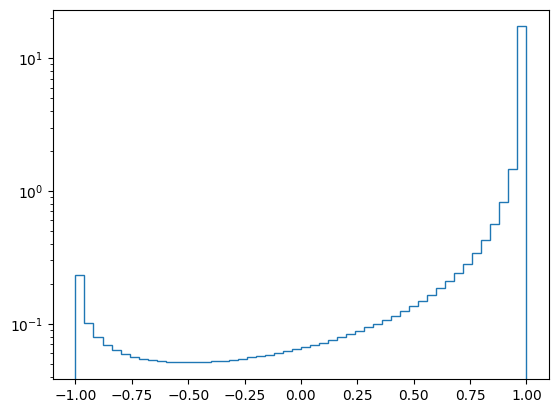

In [10]:
ks = dict(histtype='step', bins=50, density=True)

fig, ax = plt.subplots()
ax.hist(binaries['cos_theta'].flatten(), **ks)
ax.set_yscale('log');

looking for a useful distribution to fit, whose parameters we can then
inspect for correlations with population hyperpparameters ... 

/n/home03/newolfe/.conda/envs/seqpop/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


(1e-05, 10.0)

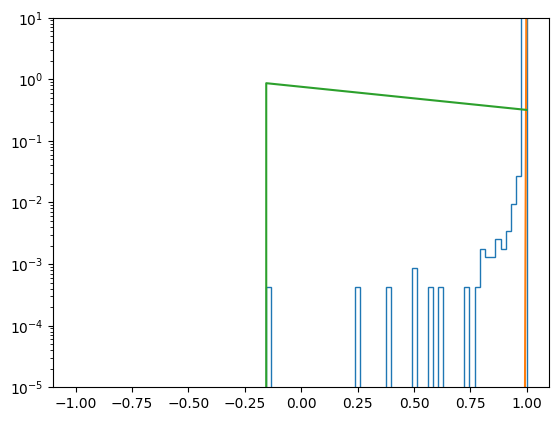

In [17]:
import numpy as np
from scipy.stats import beta, expon

beta_params = beta.fit(binaries['cos_theta'][0])
expon_params = expon.fit(binaries['cos_theta'][0])

cts = np.linspace(-1, 1, 1_000)

fig, ax = plt.subplots()
ax.hist(binaries['cos_theta'][0], **ks)
ax.plot(
    cts,
    beta.pdf(cts, *beta_params)
)
ax.plot(
    cts,
    expon.pdf(cts, *expon_params)
)
ax.set_yscale('log')
ax.set_ylim(1e-5, 1e1)

In [24]:
from arviz import hdi

hdis = []

for i in range(ntest):
    hdis.append(hdi(np.array(binaries['cos_theta'][i]), 0.9))

In [27]:
hdis = np.array(hdis)

In [34]:
parameters[key].shape

(10,)

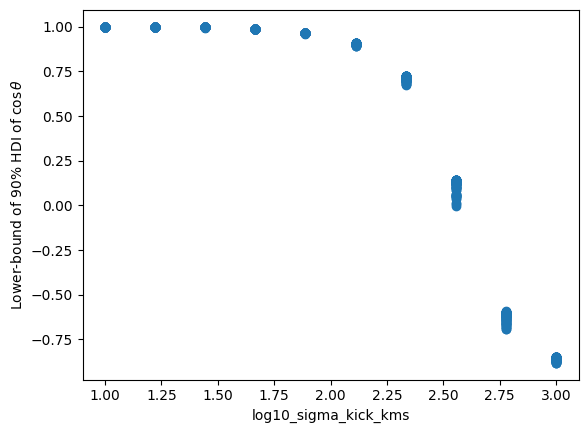

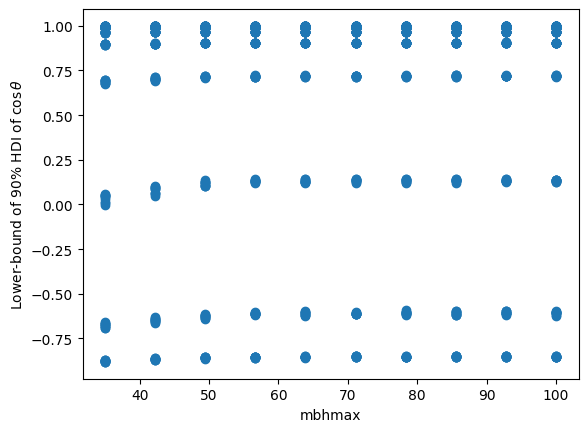

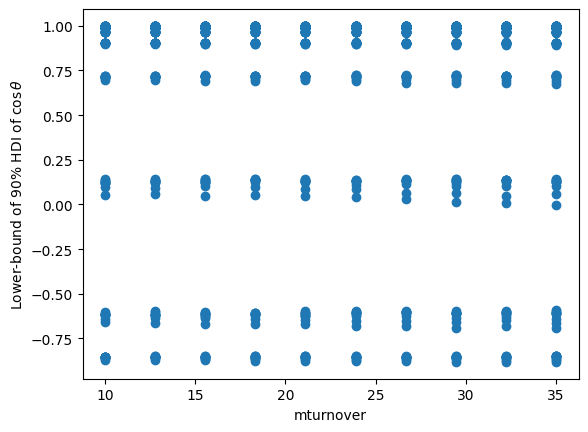

In [40]:
for key in ['log10_sigma_kick_kms', 'mbhmax', 'mturnover']:
    fig, ax = plt.subplots()
    ax.scatter(parameters[key], hdis[:, 0])
    ax.set_ylabel(r'Lower-bound of 90% HDI of $\cos \theta$')
    ax.set_xlabel(key)

Interesting... let's collect all binaries at two extremes. We'll fix `mbhmax` and `mturnover` to some fiducial values since they don't seem to matter much.

In [44]:
parameters_low_kick = dict(
    alpha_prog_1=2,
    alpha_prog_2=1.1,
    mbhmax=45,
    mturnover=34,
    sigma_mbh=1,
    sigma_kick=1e4 # [m / s]
)

from copy import deepcopy
parameters_high_kick = deepcopy(parameters_low_kick)
parameters_high_kick['sigma_kick'] = 1e6 # [m / s]

In [45]:
from astro import get_binary

@jax.jit
def get_binaries(key, parameters):
    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, 1_000_000)
    return key, jax.vmap(lambda k: get_binary(k, parameters))(keys)

In [49]:
_, binaries_low_kick = get_binaries(jax.random.key(2), parameters_low_kick)

In [51]:
jnp.sum(binaries_low_kick['survive'] & binaries_low_kick['merge']) / 1_000_000

Array(0.113863, dtype=float64)

In [50]:
_, binaries_high_kick = get_binaries(jax.random.key(2), parameters_high_kick)

In [52]:
jnp.sum(binaries_high_kick['survive'] & binaries_high_kick['merge']) / 1_000_000

Array(0.021057, dtype=float64)

In [103]:
def add_keys(binaries):
    """ add some keys for conveinence """
    binaries['u_mag'] = jnp.sqrt(jnp.sum((binaries['u_vec'])**2, axis=-1))
    binaries['log10_u_mag'] = jnp.log10(binaries['u_mag'])
    binaries['vkick_mag_kms'] = jnp.sqrt(jnp.sum((binaries['vkick_vec'])**2, axis=-1)) / 1e3
    binaries['log10_vkick_mag_kms'] = jnp.log10(binaries['vkick_mag_kms'])
    binaries['log10_vorb'] = jnp.log10(binaries['vorb'])
    binaries['log10_period'] = binaries['log_period'] / jnp.log(10)
    binaries['log10_ai'] = jnp.log10(binaries['ai'])
    binaries['log10_af'] = jnp.log10(binaries['af'])
    return binaries

In [104]:
binaries_low_kick = add_keys(binaries_low_kick)
binaries_high_kick = add_keys(binaries_high_kick)

here, we compute what the decay time *would* be if mass is lost but there is no kick

In [139]:
from astro import calc_relative_semimajoraxis
from astro import calc_orbital_decay_time
from astro import seconds_per_day, days_per_year

def get_fixed_orbit_decay_time(binaries):
    alpha = calc_relative_semimajoraxis(binaries['beta'], jnp.zeros(3,))
    af = binaries['ai'] / alpha
    t_decay = calc_orbital_decay_time(binaries['ai'], binaries['mbh1'], binaries['mbh2'])
    binaries['t_decay_fixed_years'] = t_decay / seconds_per_day / days_per_year
    return binaries

In [140]:
binaries_low_kick = get_fixed_orbit_decay_time(binaries_low_kick)
binaries_high_kick = get_fixed_orbit_decay_time(binaries_high_kick)

(1e-05, 100.0)

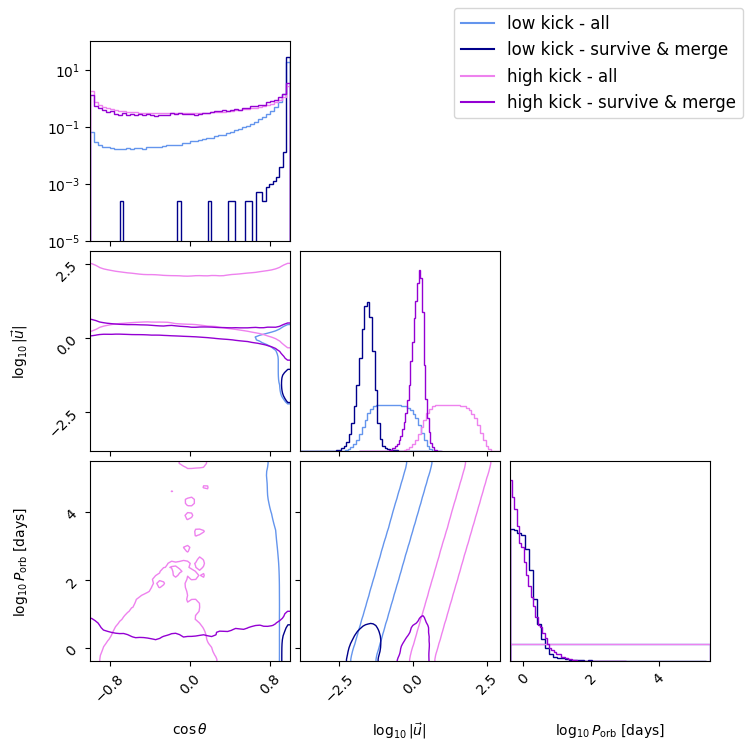

In [141]:
from util import plot_multiple

plot_keys = ['cos_theta', 'log10_u_mag', 'log10_period']

mask1 = binaries_low_kick['survive'] & binaries_low_kick['merge']
mask2 = binaries_high_kick['survive'] & binaries_high_kick['merge']

fig = plot_multiple(
    [
        np.column_stack([binaries_low_kick[k] for k in plot_keys]),
        np.column_stack([binaries_low_kick[k][mask1] for k in plot_keys]),
        np.column_stack([binaries_high_kick[k] for k in plot_keys]),
        np.column_stack([binaries_high_kick[k][mask2] for k in plot_keys])
    ],
    labels=[
        r'$\cos \theta$',
        r'$\log_{10} |\vec{u}|$',
        r'$\log_{10} P_{\rm orb}$ [days]',
        #r'$\log_{10} |\vec{v}_{\rm kick}|$ [$km / s$]'
    ],
    xs_labels=[
        'low kick - all',
        'low kick - survive & merge',
        'high kick - all',
        'high kick - survive & merge'
    ],
    colors=['cornflowerblue', 'darkblue', 'violet', 'darkviolet'],
    plot_density=False,
    plot_contours=True,
    fill_contours=False,
    no_fill_contours=True,
    plot_datapoints=False,
    levels=(0.9,)
)

fig.get_axes()[0].set_yscale('log')
fig.get_axes()[0].set_ylim(1e-5, 1e2)

In [145]:
mask1 = binaries_low_kick['survive'] & binaries_low_kick['merge']
mask2 = binaries_high_kick['survive'] & binaries_high_kick['merge']

mask3 = (binaries_low_kick['mbh1'] > 0) & (binaries_low_kick['mbh2'] > 0) & (binaries_low_kick['t_decay_fixed_years'] < 14e9)
mask4 = (binaries_high_kick['mbh1'] > 0) & (binaries_high_kick['mbh2'] > 0) & (binaries_high_kick['t_decay_fixed_years'] < 14e9) 

In [146]:
jnp.sum(mask3) / 1_000_000

Array(0.109293, dtype=float64)

In [147]:
jnp.sum(mask4) / 1_000_000

Array(0.109293, dtype=float64)

(1e-05, 100.0)

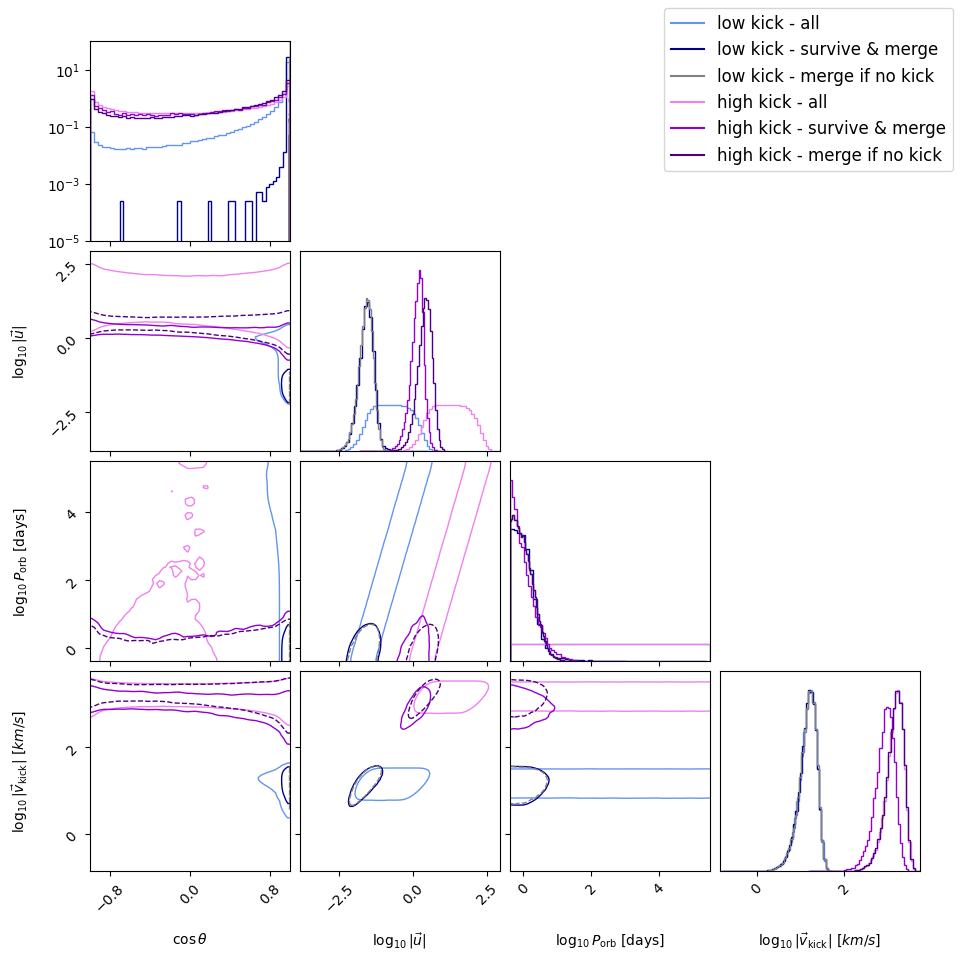

In [138]:
from util import plot_multiple

plot_keys = ['cos_theta', 'log10_u_mag', 'log10_period', 'log10_vkick_mag_kms']

fig = plot_multiple(
    [
        np.column_stack([binaries_low_kick[k] for k in plot_keys]),
        np.column_stack([binaries_low_kick[k][mask1] for k in plot_keys]),
        np.column_stack([binaries_low_kick[k][mask3] for k in plot_keys]),
        np.column_stack([binaries_high_kick[k] for k in plot_keys]),
        np.column_stack([binaries_high_kick[k][mask2] for k in plot_keys]),
        np.column_stack([binaries_high_kick[k][mask4] for k in plot_keys]),
    ],
    labels=[
        r'$\cos \theta$',
        r'$\log_{10} |\vec{u}|$',
        r'$\log_{10} P_{\rm orb}$ [days]',
        r'$\log_{10} |\vec{v}_{\rm kick}|$ [$km / s$]'
    ],
    xs_labels=[
        'low kick - all',
        'low kick - survive & merge',
        'low kick - merge if no kick',
        'high kick - all',
        'high kick - survive & merge',
        'high kick - merge if no kick'
    ],
    colors=['cornflowerblue', 'darkblue', 'grey', 'violet', 'darkviolet', 'indigo'],
    linestyles=[
        '-', '-', '--',
        '-', '-', '--'
    ],
    plot_density=False,
    plot_contours=True,
    fill_contours=False,
    no_fill_contours=True,
    plot_datapoints=False,
    levels=(0.9,)
)

fig.get_axes()[0].set_yscale('log')
fig.get_axes()[0].set_ylim(1e-5, 1e2)

(1e-05, 100.0)

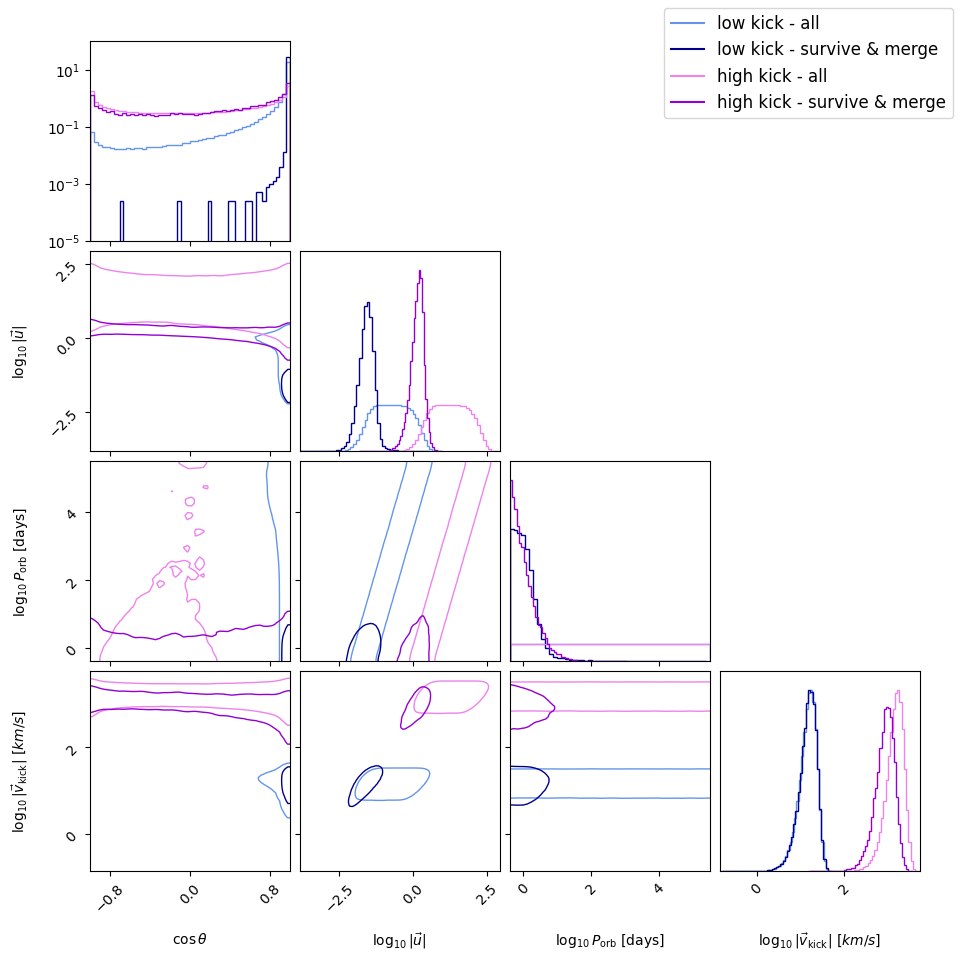

In [108]:
from util import plot_multiple

plot_keys = ['cos_theta', 'log10_u_mag', 'log10_period', 'log10_vkick_mag_kms']

mask1 = binaries_low_kick['survive'] & binaries_low_kick['merge']
mask2 = binaries_high_kick['survive'] & binaries_high_kick['merge']

fig = plot_multiple(
    [
        np.column_stack([binaries_low_kick[k] for k in plot_keys]),
        np.column_stack([binaries_low_kick[k][mask1] for k in plot_keys]),
        np.column_stack([binaries_high_kick[k] for k in plot_keys]),
        np.column_stack([binaries_high_kick[k][mask2] for k in plot_keys])
    ],
    labels=[
        r'$\cos \theta$',
        r'$\log_{10} |\vec{u}|$',
        r'$\log_{10} P_{\rm orb}$ [days]',
        r'$\log_{10} |\vec{v}_{\rm kick}|$ [$km / s$]'
    ],
    xs_labels=[
        'low kick - all',
        'low kick - survive & merge',
        'high kick - all',
        'high kick - survive & merge'
    ],
    colors=['cornflowerblue', 'darkblue', 'violet', 'darkviolet'],
    plot_density=False,
    plot_contours=True,
    fill_contours=False,
    no_fill_contours=True,
    plot_datapoints=False,
    levels=(0.9,)
)

fig.get_axes()[0].set_yscale('log')
fig.get_axes()[0].set_ylim(1e-5, 1e2)

/n/home03/newolfe/projects/tilts-and-kicks/code/util.py:86: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  fig.legend(


(1e-05, 100.0)

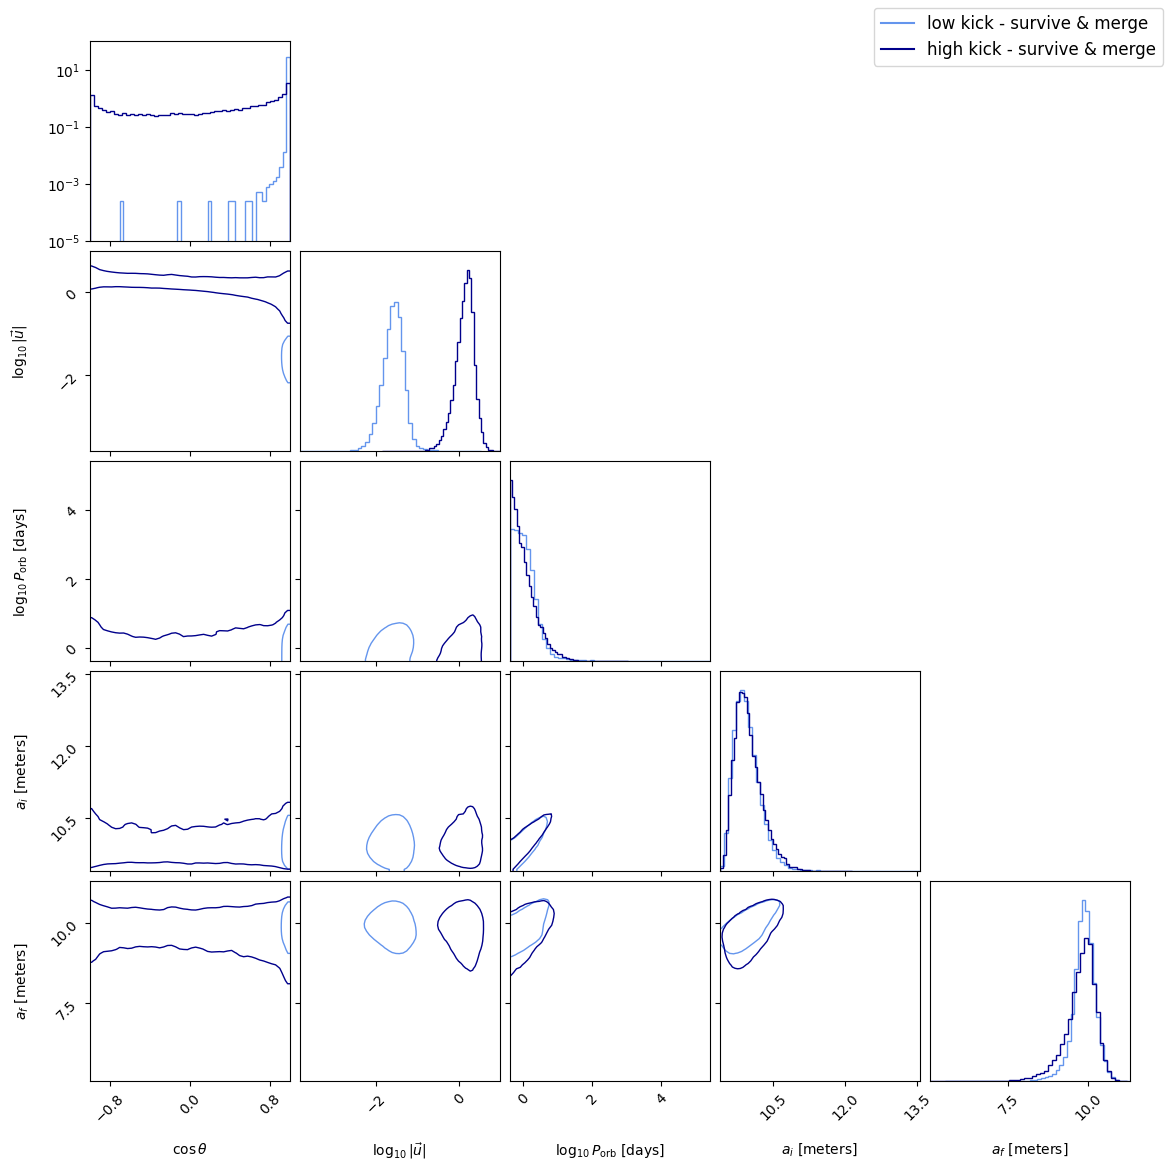

In [96]:
from util import plot_multiple

plot_keys = ['cos_theta', 'log10_u_mag', 'log10_period', 'log10_ai', 'log10_af']

mask1 = binaries_low_kick['survive'] & binaries_low_kick['merge']
mask2 = binaries_high_kick['survive'] & binaries_high_kick['merge']

fig = plot_multiple(
    [
        #np.column_stack([binaries_low_kick[k] for k in plot_keys]),
        np.column_stack([binaries_low_kick[k][mask1] for k in plot_keys]),
        #np.column_stack([binaries_high_kick[k] for k in plot_keys]),
        np.column_stack([binaries_high_kick[k][mask2] for k in plot_keys])
        #np.column_stack([binaries_high_kick[k] for k in plot_keys]),
    ],
    labels=[
        r'$\cos \theta$',
        r'$\log_{10} |\vec{u}|$',
        r'$\log_{10} P_{\rm orb}$ [days]',
        r'$a_i$ [meters]',
        r'$a_f$ [meters]'
    ],
    xs_labels=[
        #'low kick - all',
        'low kick - survive & merge',
        #'high kick - all',
        'high kick - survive & merge'
    ],
    colors=['cornflowerblue', 'darkblue', 'violet', 'darkviolet'],
    plot_density=False,
    plot_contours=True,
    fill_contours=False,
    no_fill_contours=True,
    plot_datapoints=False,
    levels=(0.9,)
)

fig.get_axes()[0].set_yscale('log')
fig.get_axes()[0].set_ylim(1e-5, 1e2)

/n/home03/newolfe/projects/tilts-and-kicks/code/util.py:86: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  fig.legend(


(1e-05, 100.0)

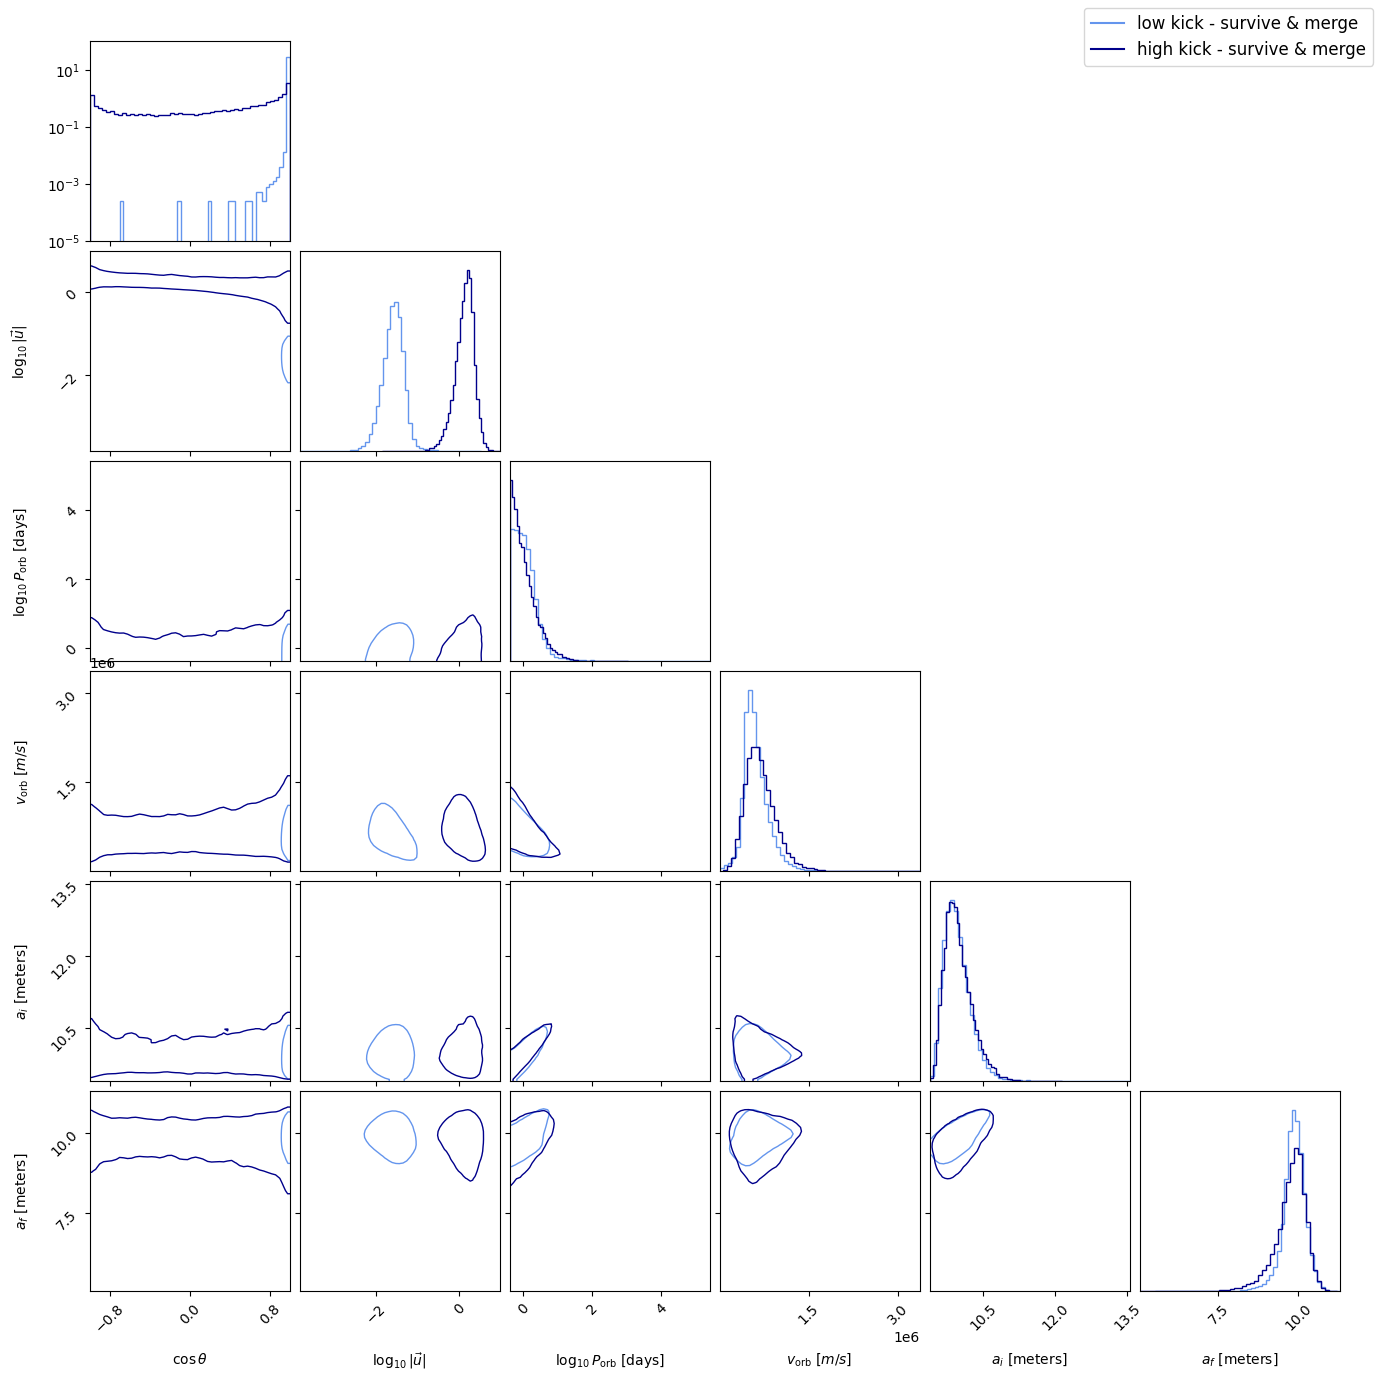

In [97]:
from util import plot_multiple

plot_keys = ['cos_theta', 'log10_u_mag', 'log10_period', 'vorb', 'log10_ai', 'log10_af']

mask1 = binaries_low_kick['survive'] & binaries_low_kick['merge']
mask2 = binaries_high_kick['survive'] & binaries_high_kick['merge']

fig = plot_multiple(
    [
        #np.column_stack([binaries_low_kick[k] for k in plot_keys]),
        np.column_stack([binaries_low_kick[k][mask1] for k in plot_keys]),
        #np.column_stack([binaries_high_kick[k] for k in plot_keys]),
        np.column_stack([binaries_high_kick[k][mask2] for k in plot_keys])
        #np.column_stack([binaries_high_kick[k] for k in plot_keys]),
    ],
    labels=[
        r'$\cos \theta$',
        r'$\log_{10} |\vec{u}|$',
        r'$\log_{10} P_{\rm orb}$ [days]',
        r'$v_{\rm orb}$ [$m / s$]',
        r'$a_i$ [meters]',
        r'$a_f$ [meters]'
    ],
    xs_labels=[
        #'low kick - all',
        'low kick - survive & merge',
        #'high kick - all',
        'high kick - survive & merge'
    ],
    colors=['cornflowerblue', 'darkblue', 'violet', 'darkviolet'],
    plot_density=False,
    plot_contours=True,
    fill_contours=False,
    no_fill_contours=True,
    plot_datapoints=False,
    levels=(0.9,)
)

fig.get_axes()[0].set_yscale('log')
fig.get_axes()[0].set_ylim(1e-5, 1e2)

(1e-05, 10.0)

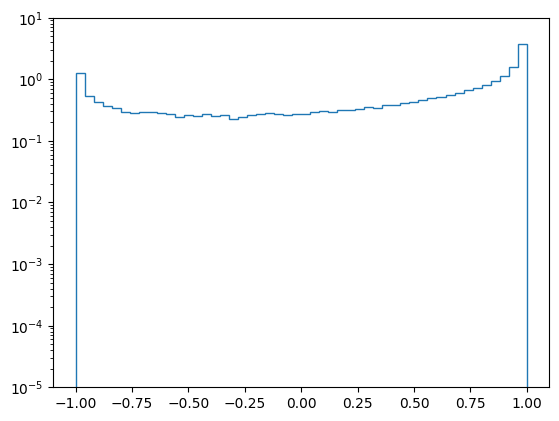

In [23]:
from arviz import hdi

data = binaries['cos_theta'][-1]
hdi(np.array(data), 0.9)


fig, ax = plt.subplots()
ax.hist(data, **ks)

ax.set_yscale('log')
ax.set_ylim(1e-5, 1e1)